# Multi-step forecasting: direct approach

In the previous notebooks, we forecasted one step ahead; that is, the CO concentration for the next hour.

In this notebook, we will predict the hourly pollutant concentration for the next 24 hours. That is, we will forecast 24 steps ahead (multi-step forecasting).

We will carry out multi-step forecasting using a direct approach.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# Same function we saw in section 2.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor", "RH"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


# Feature engineering steps

The same pipeline from the previous notebook.

In [4]:
# Datetime features
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [5]:
# Lag features.

lagf = LagFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [6]:
# Window features

winf = WindowFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [7]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [8]:
# Drop missing data
imputer = DropMissingData()

In [9]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["CO_sensor", "RH"])

# Feature engineering pipeline

In [10]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before the first forecasting point in the test set to create the input features.

In [11]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)][
    "CO_sensor"
]

# Prepare the target

In the direct approach, we build a model to predict each one of the steps in the forecasting horizon.

This means that we need to create suitable targets first:

- 1 hour ahead
- 2 hour ahead
- 3 hour ahead

...

- 24 hour ahead.

In [12]:
# The forecasting horizon.
horizon = 24

# Create an empty dataframe for the new targets.
y_train_multi = pd.DataFrame(index=y_train.index)
y_test_multi = pd.DataFrame(index=y_test.index)

# Add each one of the steps ahead.
for h in range(horizon):
    y_train_multi[f"h_{h}"] = y_train.shift(periods=-h, freq="H")
    y_test_multi[f"h_{h}"] = y_test.shift(periods=-h, freq="H")

In [13]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.

y_train_multi.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,1215.0,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,...,1136.0,1296.0,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0
2004-04-04 01:00:00,1215.0,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,...,1296.0,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0
2004-04-04 02:00:00,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,...,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0
2004-04-04 03:00:00,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,1272.0,...,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0,911.0
2004-04-04 04:00:00,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,1272.0,1160.0,...,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0,911.0,873.0


When we create our target, we will add some missing data because we obviously don't have all the information that far ahead.

In [14]:
y_train_multi.isnull().sum()

h_0       0
h_1      25
h_2      46
h_3      67
h_4      87
h_5     106
h_6     124
h_7     142
h_8     160
h_9     177
h_10    193
h_11    210
h_12    227
h_13    244
h_14    261
h_15    277
h_16    293
h_17    309
h_18    325
h_19    340
h_20    355
h_21    370
h_22    385
h_23    400
dtype: int64

In [15]:
y_test_multi.isnull().sum()

h_0      0
h_1      3
h_2      6
h_3      9
h_4     12
h_5     15
h_6     18
h_7     21
h_8     24
h_9     27
h_10    30
h_11    33
h_12    36
h_13    39
h_14    42
h_15    45
h_16    48
h_17    51
h_18    54
h_19    57
h_20    60
h_21    63
h_22    66
h_23    69
dtype: int64

In [16]:
# Let's drop the missing data points in the
# target and adjust our training and testing sets.

y_train_multi.dropna(inplace=True)
y_test_multi.dropna(inplace=True)

X_train = X_train.loc[y_train_multi.index]
X_test = X_test.loc[y_test_multi.index]

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [17]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,60.8,1224.0,56.5,1165.666667,58.566667,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,65.8,1215.0,59.2,1149.666667,61.800000,0.866025,-0.5,0.269797,0.962917
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,79.2,1115.0,62.4,1084.000000,68.600000,0.866025,-0.5,0.519584,0.854419
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,80.0,1124.0,65.0,991.666667,75.000000,0.866025,-0.5,0.730836,0.682553
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,81.0,1028.0,65.3,927.666667,80.066667,0.866025,-0.5,0.887885,0.460065


In [18]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train_multi.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(5769, 24)


In [19]:
# Lasso regression

# Using the MultiOutputRegressor, we automatically create
# one Lasso for each target.

lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(max_iter=50000, random_state=0))

In [20]:
# Make predictions

preds = lasso.predict(X_train_t)

# The predictions are made for each one of
# the targets.

preds.shape

(5769, 24)

In [21]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_train_t.columns)

preds.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,1152.872436,1081.938802,1029.199658,1014.221883,1035.531882,1086.727042,1156.940596,1209.156707,1187.625872,1113.841140,...,1171.163151,1222.690845,1258.088085,1275.446127,1249.578876,1187.135133,1110.832260,1060.559396,1059.902412,1073.437260
1,1033.061791,1005.752976,994.984547,1007.313915,1040.868570,1092.116576,1150.991837,1198.213017,1190.904396,1142.782125,...,1179.051657,1213.942910,1246.817845,1265.117799,1244.370161,1195.767090,1133.632159,1078.454911,1035.317076,999.426732
2,986.427271,998.418563,1027.787380,1063.779519,1097.559490,1127.269756,1151.036258,1175.398223,1177.356265,1156.166341,...,1213.078293,1236.129038,1259.667941,1267.646224,1235.737029,1171.396209,1092.081020,1027.252833,973.287504,929.599374
3,923.659002,953.160610,983.997455,1013.942609,1043.834950,1075.318512,1105.415924,1135.631447,1150.884676,1149.101759,...,1177.103683,1177.648294,1176.717498,1164.577476,1128.638147,1078.567197,1022.824337,972.873320,927.830151,899.502782
4,896.901441,935.173035,969.735974,998.731566,1025.928750,1055.121619,1084.698606,1113.331643,1136.144969,1148.864397,...,1145.480115,1128.390189,1106.499263,1078.811279,1042.035201,1003.797403,966.742024,931.722469,900.226307,886.962837


In [22]:
# The RMSE in the train set.

for h in range(horizon):
    rmse = mean_squared_error(preds[f"h_{h}"], y_train_t[f"h_{h}"], squared=False)
    print(f"for horizon {h} got rmse: {rmse}")

for horizon 0 got rmse: 93.06984159410605
for horizon 1 got rmse: 137.7071147109738
for horizon 2 got rmse: 161.8366595186029
for horizon 3 got rmse: 173.51942479499303
for horizon 4 got rmse: 177.79595984826702
for horizon 5 got rmse: 176.71573064553425
for horizon 6 got rmse: 170.55395342384548
for horizon 7 got rmse: 164.85136115957522
for horizon 8 got rmse: 171.05824654779556
for horizon 9 got rmse: 175.63551243070995
for horizon 10 got rmse: 174.09252789886924
for horizon 11 got rmse: 173.0303048783281
for horizon 12 got rmse: 175.65484036858226
for horizon 13 got rmse: 180.10117818062966
for horizon 14 got rmse: 184.00434982545784
for horizon 15 got rmse: 186.12551746706984
for horizon 16 got rmse: 185.298737495326
for horizon 17 got rmse: 182.36123729688885
for horizon 18 got rmse: 181.44720027346978
for horizon 19 got rmse: 181.22925925148732
for horizon 20 got rmse: 176.69406874062366
for horizon 21 got rmse: 171.0774974569061
for horizon 22 got rmse: 170.95832399978192
for h

Notice how the RMSE is worse for those values further into the future. This is normal; predictions about the furthest values in the future always have a greater uncertainty.

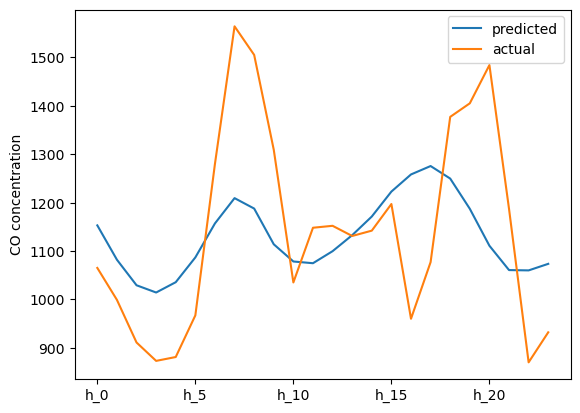

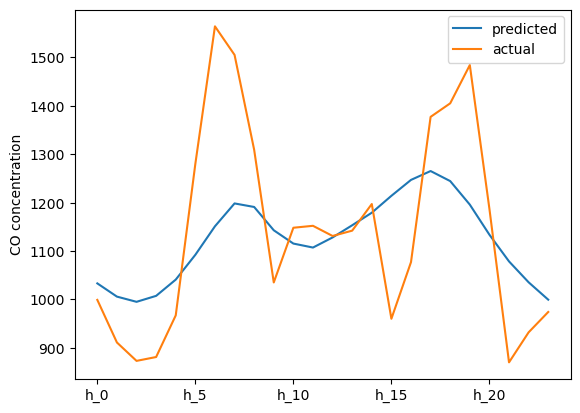

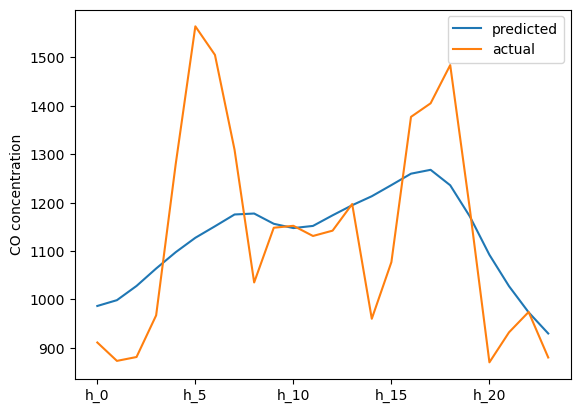

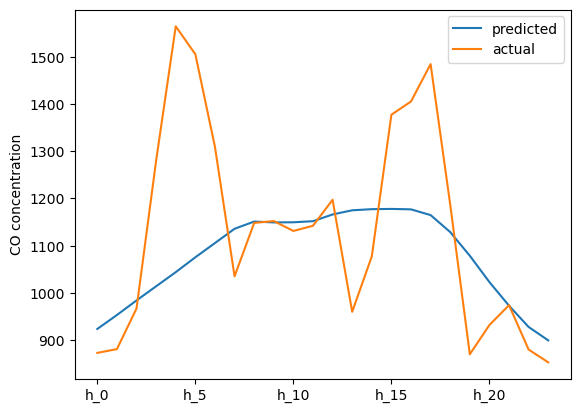

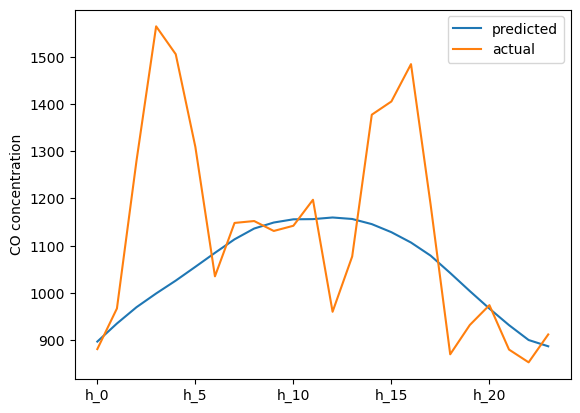

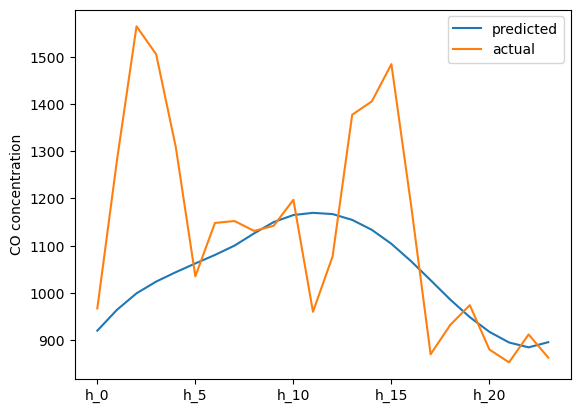

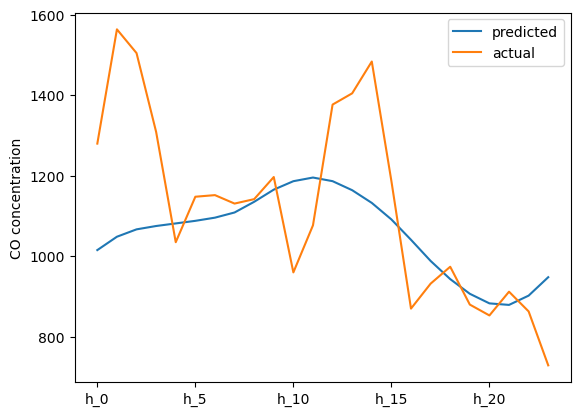

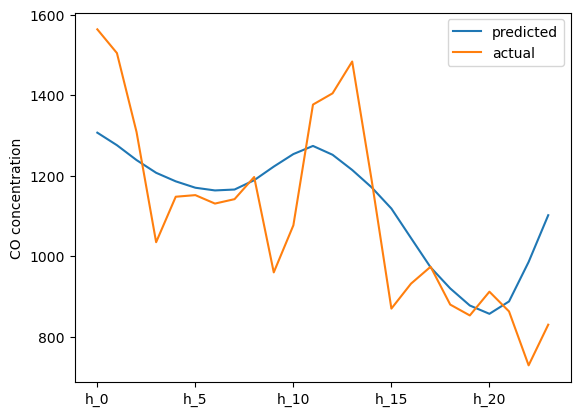

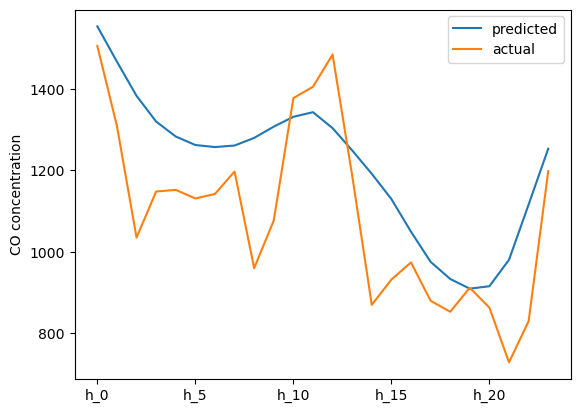

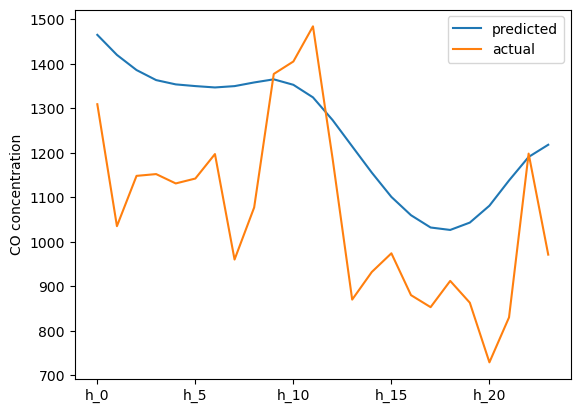

In [23]:
# Let's plot the first ten multistep forecasts
# in the train set.

# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat(
        [
            preds.iloc[i].T,
            y_train_t.iloc[i].T,
        ],
        axis=1,
    )

    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

Our model managed to get the trend of the forecast, but deviates from the real values quite a bit.

Hopefully, by the end of the course we can improve this model with more useful features :)

# Forecast 24 hours ahead in test set

We will evaluate the performance of the model in our test set now.

In [24]:
# Create the input features:

X_test_t = pipe.transform(X_test)

X_test_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2005-03-04 00:00:00,3,9,4,4,0,0,1179.0,82.0,1047.0,41.7,1223.333333,82.700000,1.0,6.123234e-17,0.000000,1.000000
2005-03-14 00:00:00,3,11,0,14,0,0,1207.0,55.6,1017.0,55.4,1201.333333,53.100000,1.0,6.123234e-17,0.000000,1.000000
2005-03-14 01:00:00,3,11,0,14,1,0,1056.0,55.9,1050.0,56.0,1157.000000,54.533333,1.0,6.123234e-17,0.269797,0.962917
2005-03-14 02:00:00,3,11,0,14,2,0,1128.0,62.1,1023.0,53.4,1130.333333,57.866667,1.0,6.123234e-17,0.519584,0.854419
2005-03-14 03:00:00,3,11,0,14,3,0,1119.0,68.9,940.0,51.8,1101.000000,62.300000,1.0,6.123234e-17,0.730836,0.682553


In [25]:
# Make predictions

preds = lasso.predict(X_test_t)

preds.shape

(426, 24)

In [26]:
print(y_test_multi.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test_multi.loc[X_test_t.index]

print(y_test_t.shape)

(498, 24)
(426, 24)


In [27]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_test_t.columns)

preds.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,1122.867321,1062.455291,1032.853059,1040.337108,1074.203578,1135.978334,1217.991003,1274.954502,1248.148873,1160.467624,...,1151.019588,1201.242335,1234.625491,1255.133049,1235.501115,1187.870324,1125.787999,1068.568355,1034.323715,1006.808840
1,1141.110779,1064.348042,1025.341192,1027.799335,1060.734918,1115.861969,1185.090781,1233.090141,1208.189613,1133.941962,...,1180.865113,1236.786773,1280.156083,1308.891837,1296.820311,1245.681729,1175.977451,1125.091503,1111.759979,1100.308906
2,1001.213440,966.570035,960.644783,982.596520,1026.596000,1087.754891,1156.083885,1206.949166,1198.004144,1148.897601,...,1168.340448,1204.836350,1241.919172,1267.950247,1261.061914,1229.752736,1182.709742,1131.411304,1079.700521,1026.413671
3,1091.097136,1051.404482,1034.178890,1041.014532,1067.464152,1106.399362,1151.895619,1191.331737,1195.122065,1175.943585,...,1210.698631,1225.916504,1235.799002,1232.746713,1207.058246,1161.171784,1106.813024,1068.441319,1052.699314,1042.960197
4,1092.345968,1069.849258,1069.493358,1084.536425,1107.909874,1132.924974,1158.009182,1184.358108,1196.409132,1198.943318,...,1224.539996,1223.737991,1218.686655,1202.358490,1170.375230,1121.826430,1067.769622,1034.485616,1023.508146,1018.814488


In [28]:
# The RMSE in the test set.

for h in range(horizon):
    rmse = mean_squared_error(preds[f"h_{h}"], y_test_t[f"h_{h}"], squared=False)
    print(f"for horizon {h} got rmse: {rmse}")

for horizon 0 got rmse: 94.31943307476466
for horizon 1 got rmse: 148.0523854519299
for horizon 2 got rmse: 179.7101264053977
for horizon 3 got rmse: 194.25672449587412
for horizon 4 got rmse: 198.97489118077038
for horizon 5 got rmse: 194.5416601549116
for horizon 6 got rmse: 179.00838534421618
for horizon 7 got rmse: 159.24817610006752
for horizon 8 got rmse: 152.56815433965448
for horizon 9 got rmse: 160.6328193942672
for horizon 10 got rmse: 156.96198378337112
for horizon 11 got rmse: 152.18193776924596
for horizon 12 got rmse: 154.85696546741627
for horizon 13 got rmse: 164.2711571975581
for horizon 14 got rmse: 176.19075215315286
for horizon 15 got rmse: 185.59534851518123
for horizon 16 got rmse: 188.46066258216885
for horizon 17 got rmse: 185.1042095045053
for horizon 18 got rmse: 176.78907249038522
for horizon 19 got rmse: 168.35414394312284
for horizon 20 got rmse: 156.20499462551658
for horizon 21 got rmse: 138.84323281930486
for horizon 22 got rmse: 136.56404677162266
for h

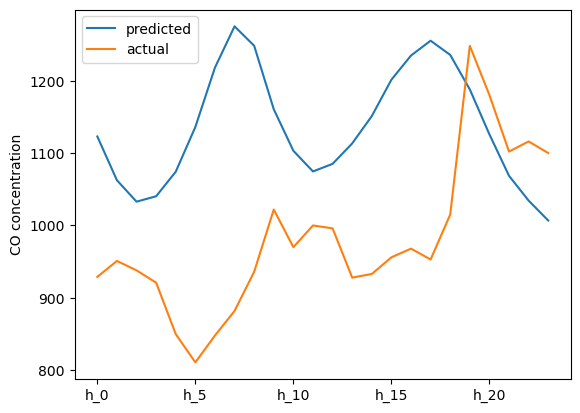

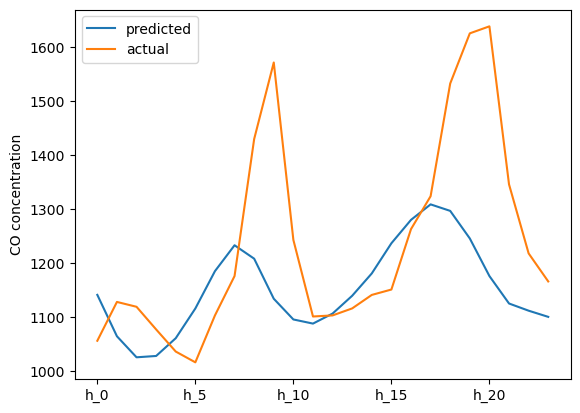

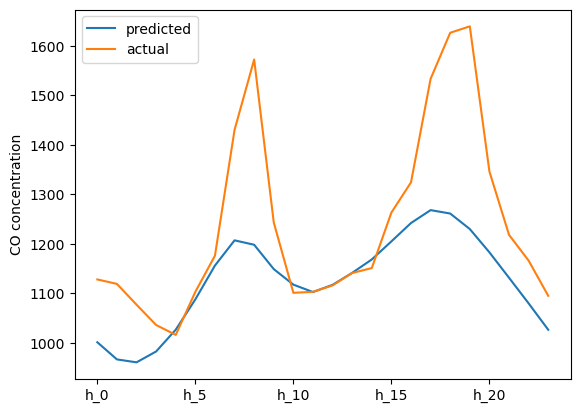

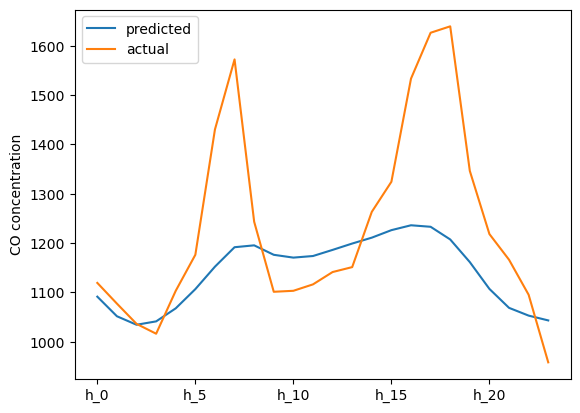

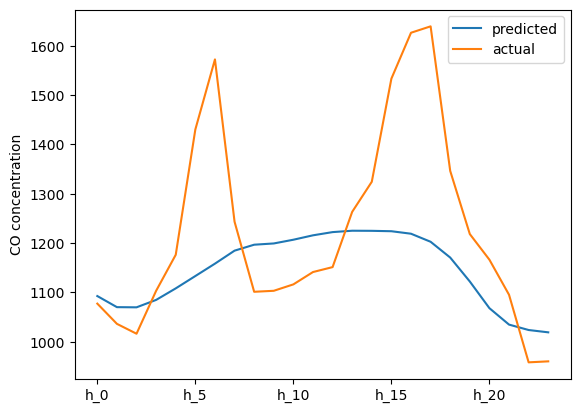

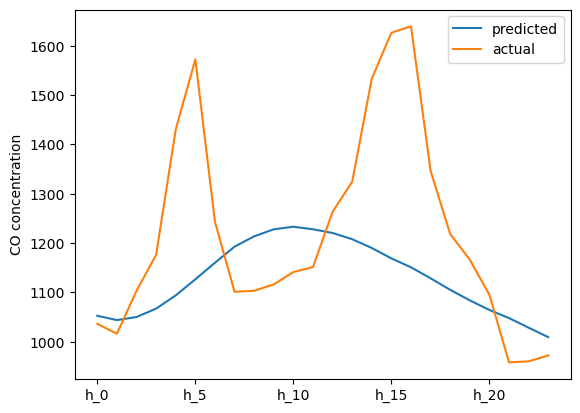

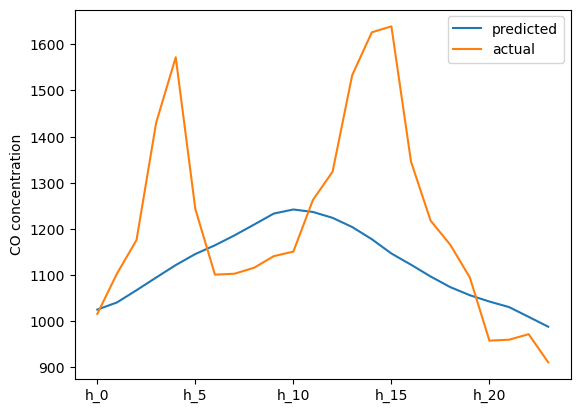

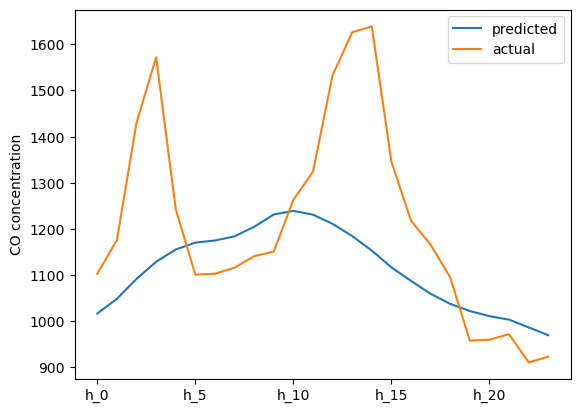

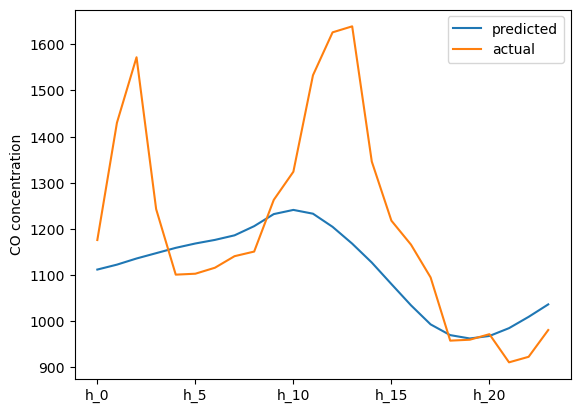

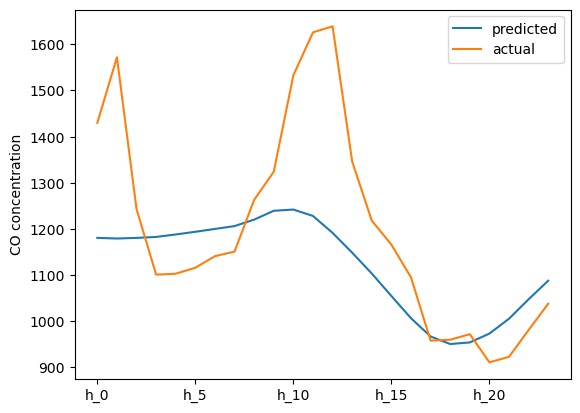

In [29]:
# Let's plot the first ten multistep forecasts
# in the train set.

# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat(
        [
            preds.iloc[i].T,
            y_test_t.iloc[i].T,
        ],
        axis=1,
    )

    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

We've seen how to implement the direct forecasting method to perform multistep forecasting.